# Testing time marching in package `Whirl`

In [1]:
cd("/Users/jeff/.julia/v0.6/Whirl")
using Pkg
pkg"activate ."

In [2]:
using Whirl

┌ Info: Recompiling stale cache file /Users/jeff/.julia/compiled/v0.7/Whirl/OnJwO.ji for Whirl [c33d41be-15db-11e9-2457-8b3af3449526]
└ @ Base loading.jl:1185


In [9]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Basic unconstrained system

First, we will solve a basic system

$\frac{\displaystyle du}{\displaystyle dt} = \cos(\omega t)$

with $u(0) = u_0$. The exact solution is

$u(t) = u_0 + \frac{\displaystyle 1}{\displaystyle \omega}\sin(\omega t)$

In [11]:
ω = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω*t)/ω

uex (generic function with 1 method)

In [12]:
Δt = 0.005
T = 0:Δt:10
u = [u₀]
TimeMarching.r₁(u::Vector{Float64},t::Float64) = cos(ω*t)
rk = RK(u,Δt,r₁,rk=TimeMarching.RK31)

Order-3 RK integator with
   State of type Array{Float64,1}
   Time step size 0.005


In [13]:
u = [u₀]
uhist = Float64[]
for t in T
    push!(uhist,u[1])
    t,u = rk(t,u)
end

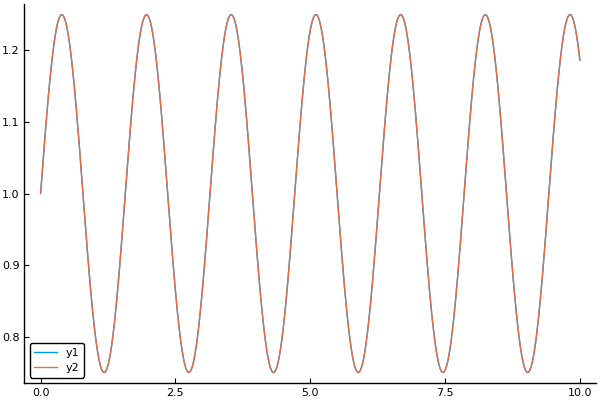

In [14]:
plot(T,uhist)
plot!(T,uex.(T))

### Unconstrained system with integrating factor

Next, we will solve an unconstrained system with an integrating factor

$\frac{\displaystyle du}{\displaystyle dt} = -\alpha u + \cos(\omega t)$

with $u(0) = u_0$. The exact solution is

$u(t) = u_0 e^{-\alpha t} + \frac{\displaystyle 1}{\displaystyle \alpha^2+\omega^2}\left(\alpha(\cos(\omega t)-e^{-\alpha t})+\omega \sin(\omega t)\right) $

In [15]:
α = 0.5
ω = 4
u₀ = 1.0
uex(t) = u₀*exp(-α*t) + (α*(cos(ω*t)-exp(-α*t))+ω*sin(ω*t))/(α^2+ω^2)

uex (generic function with 1 method)

Set up the integrating factor constructor

In [16]:
Whirl.plan_intfact(t::Float64,u::Vector{Float64}) = exp(-α*t)

In [17]:
Δt = 0.005
T = 0:Δt:10
u = [u₀]
TimeMarching.r₁(u::Vector{Float64},t::Float64) = cos(ω*t)
ifrk = IFRK(u,Δt,plan_intfact,r₁,rk=TimeMarching.RK31)

Order-3 IF-RK integator with
   State of type Array{Float64,1}
   Time step size 0.005


In [18]:
u = [u₀]
uhist = Float64[]
for t in T
    push!(uhist,u[1])
    t,u = ifrk(t,u)
end

In [20]:
using LinearAlgebra

In [21]:
LinearAlgebra.norm(uhist-uex.(T))

0.0005014844449634412

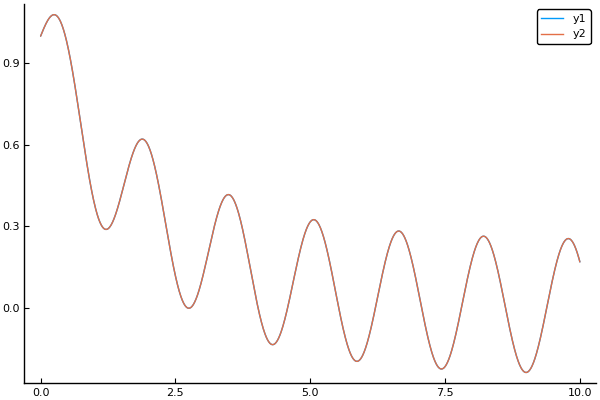

In [22]:
plot(T,uhist)
plot!(T,uex.(T))

### Constrained system with integrating factor

Now let's do a more interesting example: 2-d diffusion from a circle

In [23]:
nx = 129; ny = 129;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [24]:
n = 128;
θ = range(0,stop=2π,length=n+1);
R = 0.5;
xb = 1.0 .+ R*cos.(θ[1:n])
yb = 1.0 .+ R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f = ScalarData(X);

In [25]:
E = Regularize(X,dx;ddftype=Fields.Roma,issymmetric=true)
Hmat, Emat = RegularizationMatrix(E,f,w);

In [26]:
plan_constraints(u::Nodes{Dual,nx,ny},t::Float64) = Hmat, Emat

plan_constraints (generic function with 1 method)

In [27]:
TimeMarching.r₁(w::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = Nodes(T,w)
TimeMarching.r₂(w::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = ScalarData(ones(length(f)))

In [28]:
Δt = 1.0
ifherk = IFHERK(w,f,Δt,plan_intfact,plan_constraints,(TimeMarching.r₁,TimeMarching.r₂),rk=TimeMarching.Euler,isstored=true)

Order-1 IF-HERK integrator with
   State of type Nodes{Dual,129,129}
   Force of type ScalarData{128}
   Time step size 1.0


In [30]:
@time ifherk.S[1].B₂A⁻¹(w)
@time ifherk.S[1].S*f;
@time ifherk.S[1].A⁻¹B₁ᵀ(f);

  0.008197 seconds (14 allocations: 160.016 KiB)
  0.007766 seconds (29 allocations: 319.953 KiB)
  0.007971 seconds (14 allocations: 287.875 KiB)


In [49]:
t = 0.0
w = Nodes(Dual,(nx,ny));

In [50]:
for i = 1:20
    t,w,f = ifherk(t,w);
end     

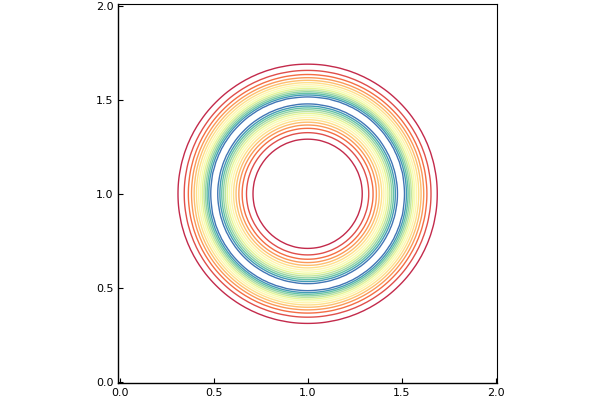

In [51]:
xg, yg = coordinates(w,dx=dx)
plot(xg,yg,w)

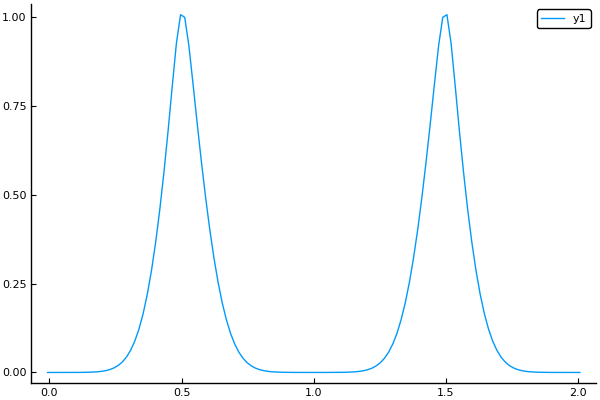

In [52]:
plot(xg,w[65,:])

### Solving basic unconstrained system with IFHERK

In [59]:
ω = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω*t)/ω

uex (generic function with 1 method)

In [63]:
t = 0.0
Δt = 0.005
T = 0:Δt:10
u = [u₀]
f = Vector{Float64}()
TimeMarching.r₁(u::Vector{Float64},t::Float64) = cos(ω*t)
TimeMarching.r₂(u::Vector{Float64},t::Float64) = Vector{Float64}()
plan_constraints(u::Vector{Float64},t::Float64) = f -> zeros(Float64,1), u -> Vector{Float64}()
Fields.plan_intfact(t::Float64,u::Vector{Float64}) = Matrix(1.0I,1,1)
ifherk = IFHERK(u,f,Δt,plan_intfact,plan_constraints,(r₁,r₂),rk=TimeMarching.RK31)

Order-3 IF-HERK integrator with
   State of type Array{Float64,1}
   Force of type Array{Float64,1}
   Time step size 0.005


In [64]:
u = [u₀]
uhist = Float64[]
for ti in T
    push!(uhist,u[1])
    t,u,_ = ifherk(t,u)
end

In [65]:
LinearAlgebra.norm(uhist-uex.(T))

0.0004948571451369004

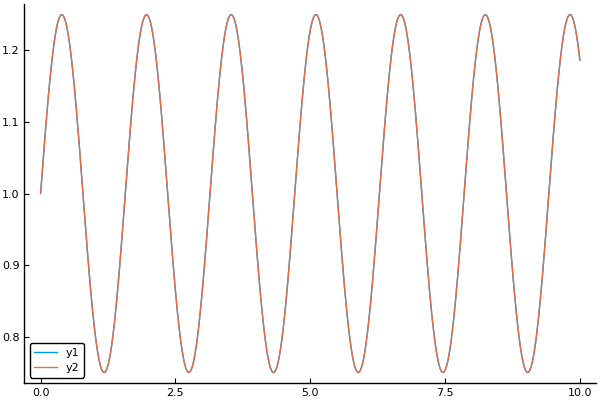

In [66]:
plot(T,uhist)
plot!(T,uex.(T))

### Advancing a combination of non-integrating factor systems

In [67]:
ω₁ = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω₁*t)/ω₁

uex (generic function with 1 method)

In [68]:
ω₂ = 2
v₀ = 0.5
vex(t) = v₀ + sin(ω₂*t)/ω₂

vex (generic function with 1 method)

Note that r₁ receives the full tuple of states and returns a tuple

In [69]:
t = 0.0
Δt = 0.005
T = 0:Δt:10
u = ([u₀],[v₀])
TimeMarching.r₁(u::Tuple{Vector{Float64},Vector{Float64}},t::Float64) =  ([cos(ω₁*t)], [cos(ω₂*t)])
rk = RK(u,Δt,TimeMarching.r₁,rk=TimeMarching.RK31)

Order-3 RK integator with
   State of type Tuple{Array{Float64,1},Array{Float64,1}}
   Time step size 0.005


In [70]:
u = ([u₀],[v₀])
u₁hist = Float64[]
u₂hist = Float64[]
for ti in T
    push!(u₁hist,u[1][1])
    push!(u₂hist,u[2][1])
    t,u = rk(t,u)
end

In [72]:
println("error for first element of tuple = ",LinearAlgebra.norm(u₁hist-uex.(T)))
println("error for second element of tuple = ",LinearAlgebra.norm(u₂hist-vex.(T)))

error for first element of tuple = 0.0004948571451369004
error for second element of tuple = 0.00024362189412486005


### Advancing a combination of integrating factor systems

In [73]:
α₁ = 0.5
ω₁ = 4
u₀ = 1.0
uex(t) = u₀*exp(-α₁*t) + (α₁*(cos(ω₁*t)-exp(-α₁*t))+ω₁*sin(ω₁*t))/(α₁^2+ω₁^2)

uex (generic function with 1 method)

In [74]:
α₂ = 0.5
ω₂ = 2
v₀ = 0.5
vex(t) = v₀*exp(-α₂*t) + (α₂*(cos(ω₂*t)-exp(-α₂*t))+ω₂*sin(ω₂*t))/(α₂^2+ω₂^2)

vex (generic function with 1 method)

In [75]:
u = ([u₀],[v₀])

([1.0], [0.5])

Set up the integrating factor constructor

In [76]:
plan1_intfact(t::Float64,u::Vector{Float64}) = exp(-α₁*t)
plan2_intfact(t::Float64,u::Vector{Float64}) = exp(-α₂*t)

plan2_intfact (generic function with 1 method)

In [77]:
t = 0.0
Δt = 0.005
T = 0:Δt:10
u = ([u₀],[v₀])
TimeMarching.r₁(u::Tuple{Vector{Float64},Vector{Float64}},t::Float64) = ([cos(ω₁*t)], [cos(ω₂*t)])
ifrk = IFRK(u,Δt,(plan1_intfact,plan2_intfact),TimeMarching.r₁,rk=TimeMarching.RK31)

Order-3 IF-RK integator with
   State of type Tuple{Array{Float64,1},Array{Float64,1}}
   Time step size 0.005


In [78]:
u = ([u₀],[v₀])
u₁hist = Float64[]
u₂hist = Float64[]
for ti in T
    push!(u₁hist,u[1][1])
    push!(u₂hist,u[2][1])
    t,u = ifrk(t,u)
end

In [79]:
println("error for first element of tuple = ",LinearAlgebra.norm(u₁hist-uex.(T)))
println("error for second element of tuple = ",LinearAlgebra.norm(u₂hist-vex.(T)))

error for first element of tuple = 0.0005014844446813186
error for second element of tuple = 0.00025562080196897416


### Advancing a combination of constrained integrating factor system and basic system

System 1

In [3]:
nx = 129; ny = 129;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [4]:
n = 128;
θ = range(0,stop=2π,length=n+1);
R = 0.5;
xb = 1.0 .+ R*cos.(θ[1:n])
yb = 1.0 .+ R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f1 = ScalarData(X);

System 2

In [5]:
ω₁ = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω₁*t)/ω₁

uex (generic function with 1 method)

Set up the state vector tuple and force tuple

In [6]:
u = (w,[u₀])
f = (f1,Vector{Float64}())
TU = typeof(u)
TF = typeof(f)

Tuple{ScalarData{128},Array{Float64,1}}

In [7]:
E = Regularize(X,dx;issymmetric=true)
Hmat, Emat = RegularizationMatrix(E,f1,w);

Set up the operators

In [8]:
using LinearAlgebra

In [14]:
TimeMarching.r₁(u::TU,t::Float64) = (Nodes(Dual,w),[cos(ω₁*t)])
TimeMarching.r₂(u::TU,t::Float64) = (ScalarData(ones(length(f1))),Vector{Float64}())
plans = (Fields.plan_intfact,(t,u) -> Matrix(1.0LinearAlgebra.I,1,1))
plan_constraints(u::TU,t::Float64) = ((Hmat,f->zeros(Float64,1)),(Emat,u->Vector{Float64}()))

plan_constraints (generic function with 1 method)

In [15]:
Δt = 0.01
ifherk = IFHERK(u,f,Δt,plans,plan_constraints,(TimeMarching.r₁,TimeMarching.r₂),rk=TimeMarching.Euler,isstored=true)

Order-1 IF-HERK integrator with
   State of type Tuple{Nodes{Dual,129,129},Array{Float64,1}}
   Force of type Tuple{ScalarData{128},Array{Float64,1}}
   Time step size 0.01


In [11]:
ifherk(0.0,u)

(0.01, (Dual nodes in a (nx = 129, ny = 129) cell grid
  Number of Dual nodes: (nx = 129, ny = 129), [1.01]), ([-309.916, -317.342, -312.847, -315.273, -311.476, -313.018, -312.504, -310.863, -312.193, -305.813  …  -318.491, -305.813, -312.193, -310.863, -312.504, -313.018, -311.476, -315.273, -312.847, -317.342], Float64[]))

### Update operators in each stage